In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('/Users/yaroslav/Documents/Python/JupyterProject/Lab_2/data/olist_customers_dataset.csv')
orders = pd.read_csv('/Users/yaroslav/Documents/Python/JupyterProject/Lab_2/data/olist_orders_dataset.csv')
items = pd.read_csv('/Users/yaroslav/Documents/Python/JupyterProject/Lab_2/data/olist_order_items_dataset.csv')
products = pd.read_csv('/Users/yaroslav/Documents/Python/JupyterProject/Lab_2/data/olist_products_dataset.csv')
payments = pd.read_csv('/Users/yaroslav/Documents/Python/JupyterProject/Lab_2/data/olist_order_payments_dataset.csv')

datasets = {
    "customers": customers,
    "orders": orders,
    "items": items,
    "products": products,
    "payments": payments
}

In [3]:
for name, df in datasets.items():
    print(f"\n===== {name.upper()} =====")
    print("Размер:", df.shape)
    print("Первые 3 строки:")
    print(df.head(3))
    print("Типы данных:")
    print(df.dtypes)

summary = pd.DataFrame({
    "dataset": datasets.keys(),
    "rows": [df.shape[0] for df in datasets.values()],
    "columns": [df.shape[1] for df in datasets.values()],
    "missing_values": [df.isna().sum().sum() for df in datasets.values()]
})
print("\n===== СВОДНАЯ ТАБЛИЦА =====")
print(summary)


===== CUSTOMERS =====
Размер: (99441, 5)
Первые 3 строки:
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
Типы данных:
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

===== ORDERS =====
Размер: (99441, 8)
Первые 3 строки:
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb

In [4]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")

orders = orders.drop_duplicates(subset="order_id")
orders = orders.dropna(subset=["order_purchase_timestamp"])

products = products.fillna({
    "product_category_name": "unknown"
})

In [5]:
df = orders.merge(customers, on="customer_id", how="left") \
           .merge(items, on="order_id", how="left") \
           .merge(products, on="product_id", how="left") \
           .merge(payments, on="order_id", how="left")

print("\nРазмер объединённого датасета:", df.shape)


Размер объединённого датасета: (118434, 30)


In [6]:
df["delivery_time_days"] = (
    df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
).dt.days

df["delivery_delay"] = (
    df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]
).dt.days

df["order_total"] = df["price"] + df["freight_value"]

df["year"] = df["order_purchase_timestamp"].dt.year
df["month"] = df["order_purchase_timestamp"].dt.month
df["quarter"] = df["order_purchase_timestamp"].dt.quarter
df["day"] = df["order_purchase_timestamp"].dt.day
df["weekday"] = df["order_purchase_timestamp"].dt.dayofweek
df["hour"] = df["order_purchase_timestamp"].dt.hour

def get_season(m):
    if m in [12,1,2]: return "winter"
    if m in [3,4,5]: return "spring"
    if m in [6,7,8]: return "summer"
    return "autumn"

df["season"] = df["month"].apply(get_season)

def time_of_day(h):
    if 5 <= h < 12: return "morning"
    if 12 <= h < 18: return "day"
    if 18 <= h < 23: return "evening"
    return "night"

df["daytime"] = df["hour"].apply(time_of_day)

In [7]:
print("\n===== МЕТРИКИ =====")

total_revenue = df["order_total"].sum()
print("Общая выручка:", total_revenue)

aov = df["order_total"].mean()
print("Средний чек (AOV):", aov)

print("Средняя цена товара:", df["price"].mean())
print("Средняя стоимость доставки:", df["freight_value"].mean())

unique_customers = df["customer_unique_id"].nunique()
print("Уникальных клиентов:", unique_customers)

order_count = df["order_id"].nunique()
print("Всего заказов:", order_count)

print("Среднее кол-во заказов на клиента:", order_count / unique_customers)

order_times = df.groupby("customer_unique_id")["order_purchase_timestamp"]\
                .apply(lambda x: x.sort_values().diff().mean())
print("Среднее время между заказами:", order_times.mean())

print("Среднее время доставки (дни):", df["delivery_time_days"].mean())

on_time = (df["delivery_delay"] <= 0).mean() * 100
print("Процент вовремя доставленных заказов:", on_time)

print("Уникальных продуктов:", df["product_id"].nunique())
print("Уникальных категорий:", df["product_category_name"].nunique())

items_per_order = df.groupby("order_id")["order_item_id"].count().mean()
print("Среднее количество товаров в заказе:", items_per_order)

print(df["payment_type"].value_counts(normalize=True) * 100)


===== МЕТРИКИ =====
Общая выручка: 16566687.309999999
Средний чек (AOV): 140.86839996938878
Средняя цена товара: 120.82284879765996
Средняя стоимость доставки: 20.045551171728857
Уникальных клиентов: 96096
Всего заказов: 99441
Среднее кол-во заказов на клиента: 1.0348089410589412
Среднее время между заказами: 14 days 00:47:09.296836477
Среднее время доставки (дни): 12.019237288872276
Процент вовремя доставленных заказов: 90.77376429065977
Уникальных продуктов: 32951
Уникальных категорий: 74
Среднее количество товаров в заказе: 1.182651019197313
payment_type
credit_card    73.701987
boleto         19.451833
voucher         5.409901
debit_card      1.433746
not_defined     0.002533
Name: proportion, dtype: float64


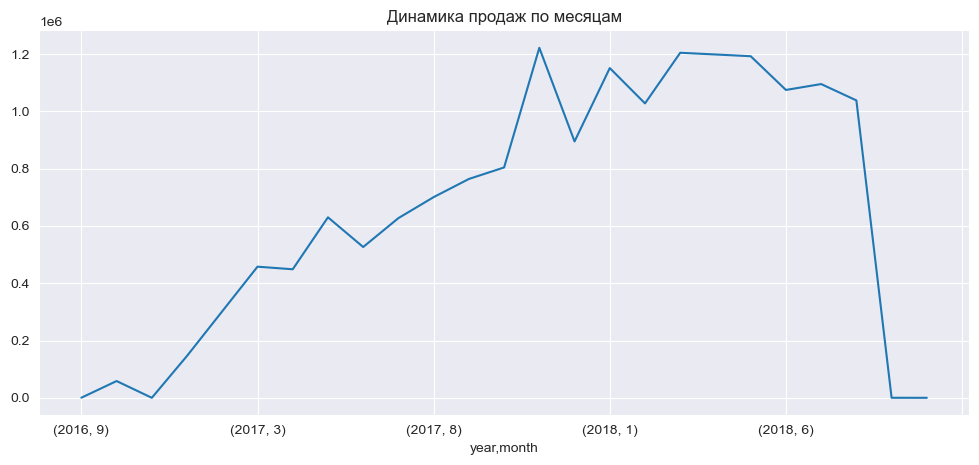

In [8]:
plt.figure(figsize=(12,5))
df.groupby(["year","month"])["order_total"].sum().plot()
plt.title("Динамика продаж по месяцам")
plt.show()

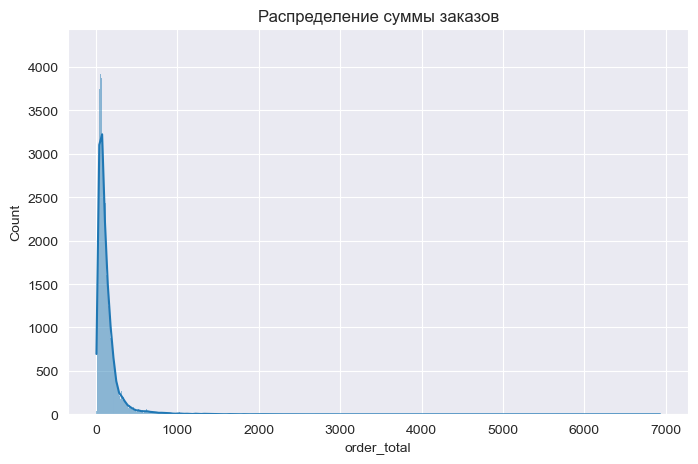

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df["order_total"], kde=True)
plt.title("Распределение суммы заказов")
plt.show()

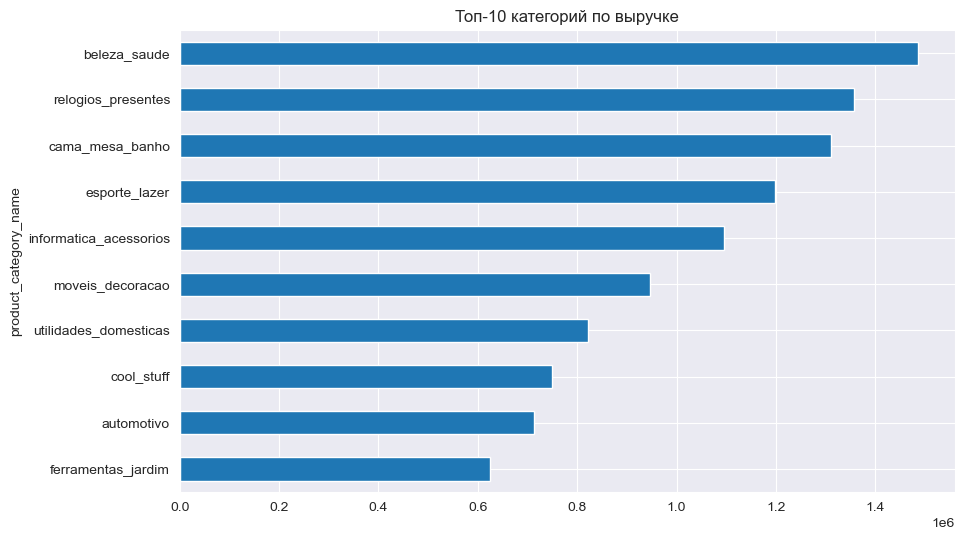

In [10]:
top_cat = df.groupby("product_category_name")["order_total"].sum()\
            .sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
top_cat.plot(kind="barh")
plt.title("Топ-10 категорий по выручке")
plt.gca().invert_yaxis()
plt.show()

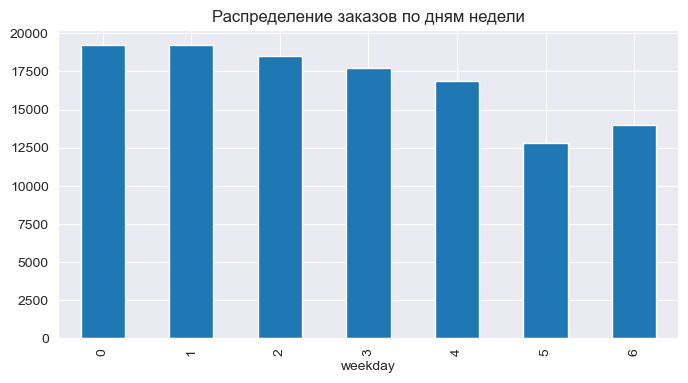

In [11]:
plt.figure(figsize=(8,4))
df["weekday"].value_counts().sort_index().plot(kind="bar")
plt.title("Распределение заказов по дням недели")
plt.show()

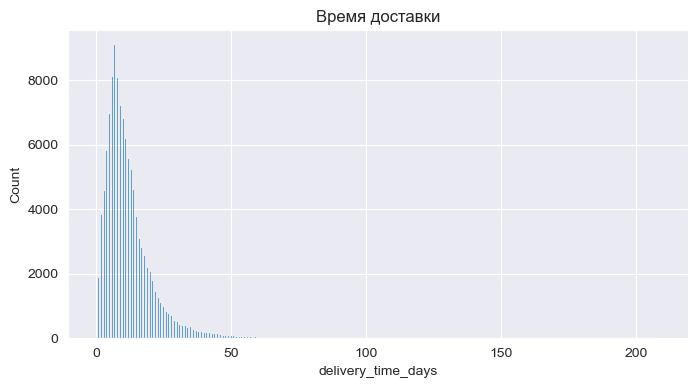

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df["delivery_time_days"], kde=False)
plt.title("Время доставки")
plt.show()

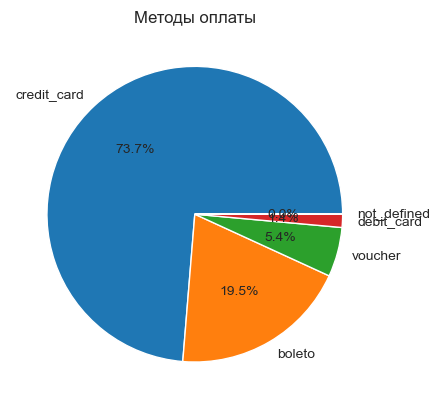

In [13]:
df["payment_type"].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Методы оплаты")
plt.ylabel("")
plt.show()

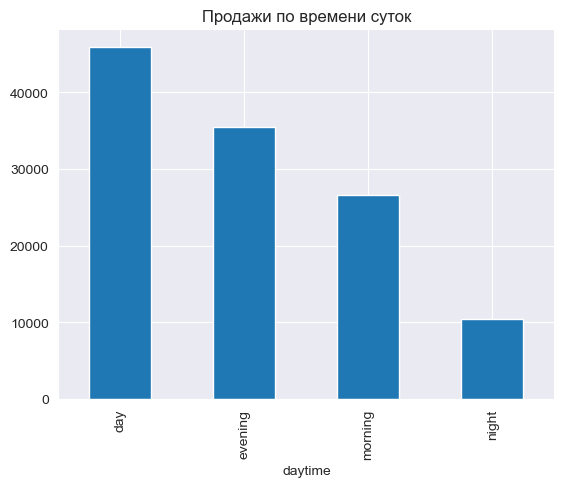

In [14]:
df["daytime"].value_counts().plot(kind="bar")
plt.title("Продажи по времени суток")
plt.show()

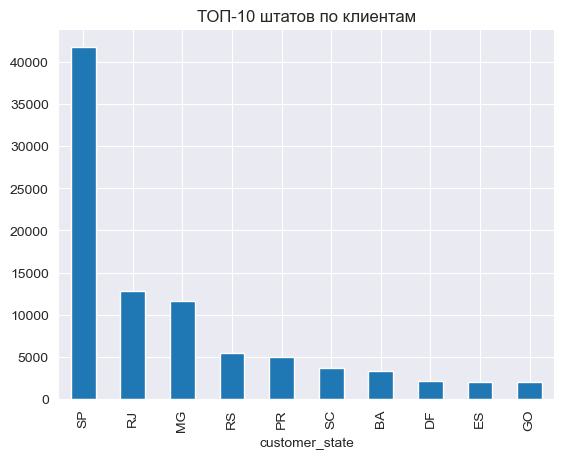

In [15]:
customers["customer_state"].value_counts().head(10).plot(kind="bar")
plt.title("ТОП-10 штатов по клиентам")
plt.show()

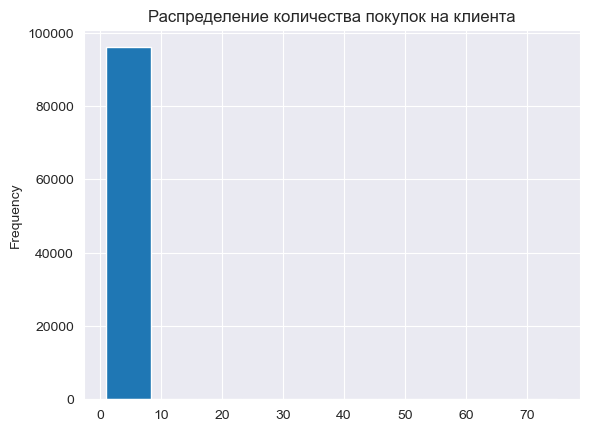

In [16]:
df["customer_unique_id"].value_counts().plot(kind="hist")
plt.title("Распределение количества покупок на клиента")
plt.show()

In [18]:
latest_date = df["order_purchase_timestamp"].max()

rfm = df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp": lambda x: (latest_date - x.max()).days,
    "order_id": "nunique",
    "order_total": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm["R_rank"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1], duplicates='drop')

rfm["F_rank"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M_rank"] = pd.qcut(rfm["Monetary"].rank(method="first"), 4, labels=[1,2,3,4])

rfm["RFM_score"] = rfm["R_rank"].astype(int) + rfm["F_rank"].astype(int) + rfm["M_rank"].astype(int)

In [19]:
def segment(score):
    if score >= 10: return "VIP / Лучшие"
    if score >= 7: return "Лояльные"
    if score >= 5: return "Средние"
    return "Новые / Ушедшие"

rfm["segment"] = rfm["RFM_score"].apply(segment)

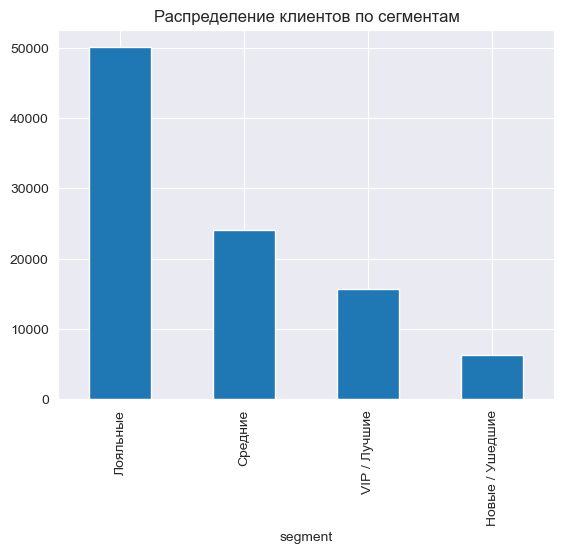

In [20]:
rfm["segment"].value_counts().plot(kind="bar")
plt.title("Распределение клиентов по сегментам")
plt.show()